# <b>Imoprting Dataset <b>

In [1]:
import torch
import torch.nn as nn 
import torch.optim  as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
import numpy as np
import time
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224),  # Image resizing to 224x224
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
PATH = "Lumpy Skin Images Dataset"
data = datasets.ImageFolder(root=PATH , transform = transform)

In [4]:
data

Dataset ImageFolder
    Number of datapoints: 1024
    Root location: Lumpy Skin Images Dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
class_names = data.class_to_idx 
data.class_to_idx, data.classes

({'Lumpy Skin': 0, 'Normal Skin': 1}, ['Lumpy Skin', 'Normal Skin'])

In [6]:
data[0]

(tensor([[[-0.2342,  0.1465,  0.0627,  ..., -1.4262, -1.3136, -1.3302],
          [-0.2848,  0.0959,  0.0957,  ..., -1.4255, -1.3010, -1.3175],
          [-0.2640,  0.0886,  0.0166,  ..., -1.3898, -1.3152, -1.3130],
          ...,
          [-0.7634, -0.5886, -0.5300,  ...,  0.3884,  0.4458,  0.2364],
          [-0.5341, -0.4075, -0.5169,  ...,  0.3625,  0.3908,  0.3138],
          [-0.2684, -0.2519, -0.1381,  ...,  0.3442,  0.2807,  0.3138]],
 
         [[-0.9153, -0.5430, -0.6789,  ..., -1.2751, -1.1417, -1.1078],
          [-0.9670, -0.5947, -0.6451,  ..., -1.2751, -1.1421, -1.1208],
          [-0.9457, -0.6117, -0.7172,  ..., -1.2575, -1.1617, -1.1352],
          ...,
          [-0.7911, -0.5932, -0.5212,  ...,  0.6315,  0.6902,  0.4762],
          [-0.5566, -0.4272, -0.5556,  ...,  0.6051,  0.6340,  0.5553],
          [-0.2850, -0.2681, -0.1683,  ...,  0.5864,  0.5215,  0.5553]],
 
         [[-0.9156, -0.4776, -0.5447,  ..., -0.8894, -0.7413, -0.7413],
          [-0.9671, -0.5166,

In [7]:
data[0][0].size()  # RGB 3 (224 , 224)

torch.Size([3, 224, 224])

# <b>Spliting it into Train and Test dataset<b>

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2)

In [9]:
dataset_sizes = {'train': len(train_data) , 'test':len(test_data)}
len(train_data), len(test_data)

(819, 205)

In [10]:
training_data = DataLoader(train_data , batch_size = 64 , shuffle = True)
testing_data = DataLoader(test_data , batch_size = 64 , shuffle = True)
dataloaders = {"train":training_data, "test":testing_data}

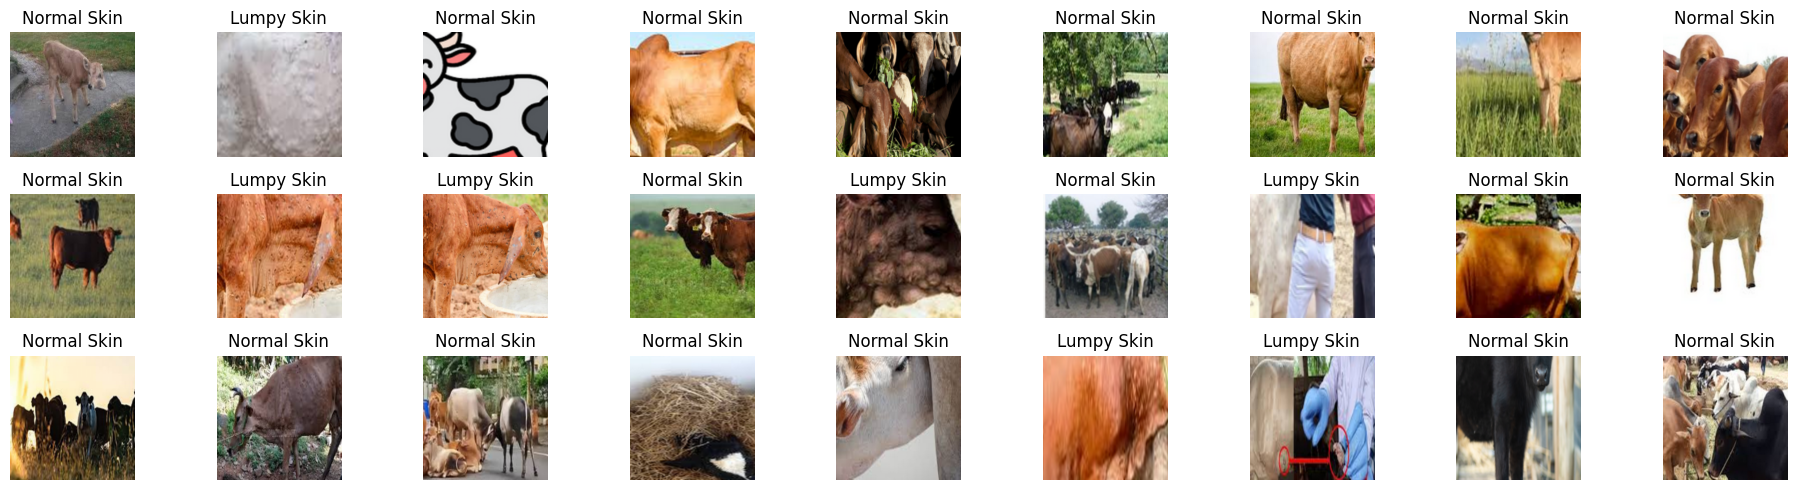

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(1, 1, 3)
    std = torch.tensor(std).reshape(1, 1, 3)
    return tensor * std + mean

row = 3
col = 9
fig, axs = plt.subplots(row, col, figsize=(col+10,5 )) 
axs = axs.flatten()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

for i in range(row*col):
    pixels = train_data[i][0]
    label = train_data[i][1]

    pixels = denormalize(pixels.permute(1, 2, 0), mean, std)
    pixels = torch.clamp(pixels, 0, 1)

    axs[i].imshow(pixels)
    axs[i].set_title(f'{data.classes[label]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# <b>Transfer Learning of ResNet50<b>

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = torch.as_tensor(labels).to(device)
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

### **Create function to visualize our model's predictions**

In [18]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(num_images // 2, 2, figsize=(10, 10))
    axs = axs.flatten()

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far >= num_images:
                    break

                ax = axs[images_so_far]
                ax.axis('off')
                ax.set_title(f'Predicted: {data.classes[preds[j]]}') 
                imshow(inputs.cpu().data[j], ax)
                images_so_far += 1

            if images_so_far >= num_images:
                break

    for idx in range(images_so_far, num_images):
        axs[idx].axis('off')

    model.train(mode=was_training)

def imshow(tensor, ax):
    tensor = tensor.permute(1, 2, 0)
    tensor = torch.clamp(tensor, 0, 1)  # Clipping the tensor values to [0, 1]
    ax.imshow(tensor.numpy())


In [22]:
model_ft = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=50)

Epoch 1/50
----------
train Loss: 0.5704 Acc: 0.7033
test Loss: 0.4771 Acc: 0.7756

Epoch 2/50
----------
train Loss: 0.4009 Acc: 0.8376
test Loss: 0.3679 Acc: 0.8878

Epoch 3/50
----------
train Loss: 0.2821 Acc: 0.8987
test Loss: 0.3468 Acc: 0.8780

Epoch 4/50
----------
train Loss: 0.2137 Acc: 0.9231
test Loss: 0.3380 Acc: 0.8829

Epoch 5/50
----------


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


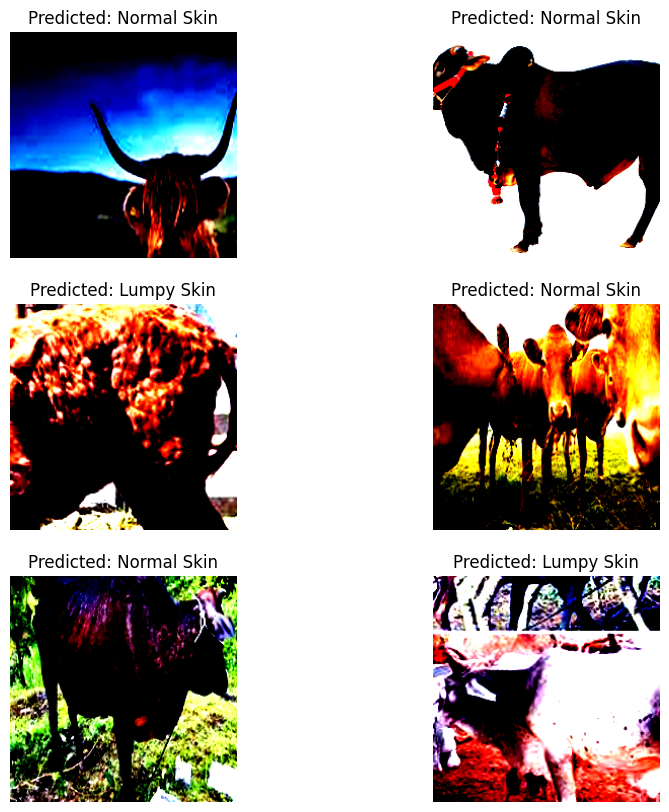

In [19]:
visualize_predictions(model_ft)